In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [2]:
train_data_path = 'DEEPSAT6/X_train_sat6.csv'
train_label_path = 'DEEPSAT6/y_train_sat6.csv'
test_data_path = 'DEEPSAT6/X_test_sat6.csv'
test_label_path = 'DEEPSAT6/y_test_sat6.csv'

In [3]:
x_train = pd.read_csv(train_data_path, header=None, dtype='uint8')
y_train = pd.read_csv(train_label_path, header=None, dtype='uint8')
x_test = pd.read_csv(test_data_path, header=None, dtype='uint8')
y_test = pd.read_csv(test_label_path, header=None, dtype='uint8')

In [4]:
print("Train data shape: ", x_train.shape)
print("Train label shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test label shape: ", y_test.shape)

Train data shape:  (324000, 3136)
Train label shape:  (324000, 6)
Test data shape:  (81000, 3136)
Test label shape:  (81000, 6)


In [5]:
x_train = x_train.values.reshape([-1,28,28,4])
x_test = x_test.values.reshape([-1,28,28,4])

x_train.shape, x_test.shape

((324000, 28, 28, 4), (81000, 28, 28, 4))

In [6]:
class_names = ['Construction', 'Road', 'Grassland', 'Barren', 'Water', 'Treecover']
class_count = len(class_names)

print("Num. classes: %d" % class_count)
print("Class names:", class_names)

Num. classes: 6
Class names: ['Construction', 'Road', 'Grassland', 'Barren', 'Water', 'Treecover']


In [7]:
def label_converter(values):
  if values[0] == 1:    # Building 
    return 0
  elif values[1] == 1:  # Barren land 
    return 3
  elif values[2] == 1:  # Trees
    return 5
  elif values[3] == 1:  # Grassland
    return 2
  elif values[4] == 1:  # Road
    return 1
  elif values[5] == 1:  # Water
    return 4
  else:
    return None

In [8]:
y_train = y_train.apply(label_converter, axis=1).values.ravel().astype('uint8')
#y_train = train_label.values.ravel().astype('uint8')
#y_train = train_label.apply(label_converter, axis=1).astype('category')
y_train

array([5, 3, 4, ..., 4, 2, 3], dtype=uint8)

In [9]:
y_test = y_test.apply(label_converter, axis=1).values.ravel().astype('uint8')
#y_test = test_label.values.ravel().astype('uint8')
#y_test = test_label.apply(label_converter, axis=1).astype('category')
y_test

array([5, 5, 4, ..., 5, 4, 5], dtype=uint8)

In [10]:
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([ 3714,  2070, 12596, 18367, 30068, 14185], dtype=int64))

In [11]:
def show_samples(data, labels):
    fig = plt.figure(figsize=(16, 8))
    ax = []
    rows, columns = 4, 8
    
    for i in range(columns * rows):
        index = np.random.randint(1, 500)
        img = data[index].reshape([28,28,4])[:,:,:3]
        class_name = class_names[labels[index]]
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title(class_name)
        plt.axis("off")
        plt.imshow(img)

    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.show()

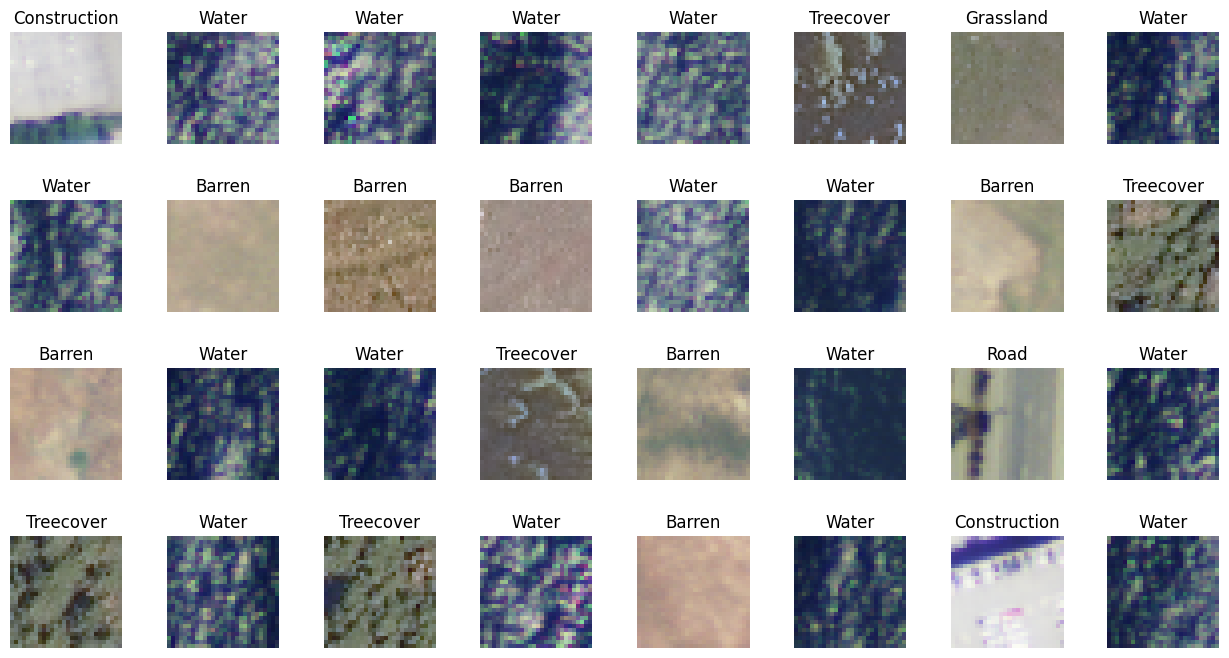

In [12]:
show_samples(x_train, y_train)

In [13]:
def show_sample_histogram(data, labels, index=None):

    if not index:
        index = np.random.randint(1, len(labels))

    fig = plt.figure(figsize=(12, 6))
    ax = []
    rows, columns = 1, 2
    colors = ("red", "green", "blue", "purple")
    channel_ids = (0, 1, 2, 3)

    all = data[index].reshape([28, 28, 4])

    class_name = class_names[labels[index]]
    rgb = all[:,:,:3]
    ax.append(fig.add_subplot(rows, columns, 1))
    ax[-1].set_title(class_name, fontsize=20)
    plt.axis("off")
    plt.imshow(rgb)

    ax.append(fig.add_subplot(rows, columns, 2))
    ax[-1].set_xlim([0, 256])
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            all[:, :, channel_id], bins=256, range=(0, 256))
        ax[-1].plot(bin_edges[0:-1], histogram, color=c, linewidth=0.8)
        ax[-1].set_title('Histograma dos pixels', fontsize=20)
        ax[-1].legend(['R', 'G', 'B', 'NIR'])

    fig.tight_layout()

    #plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.show()

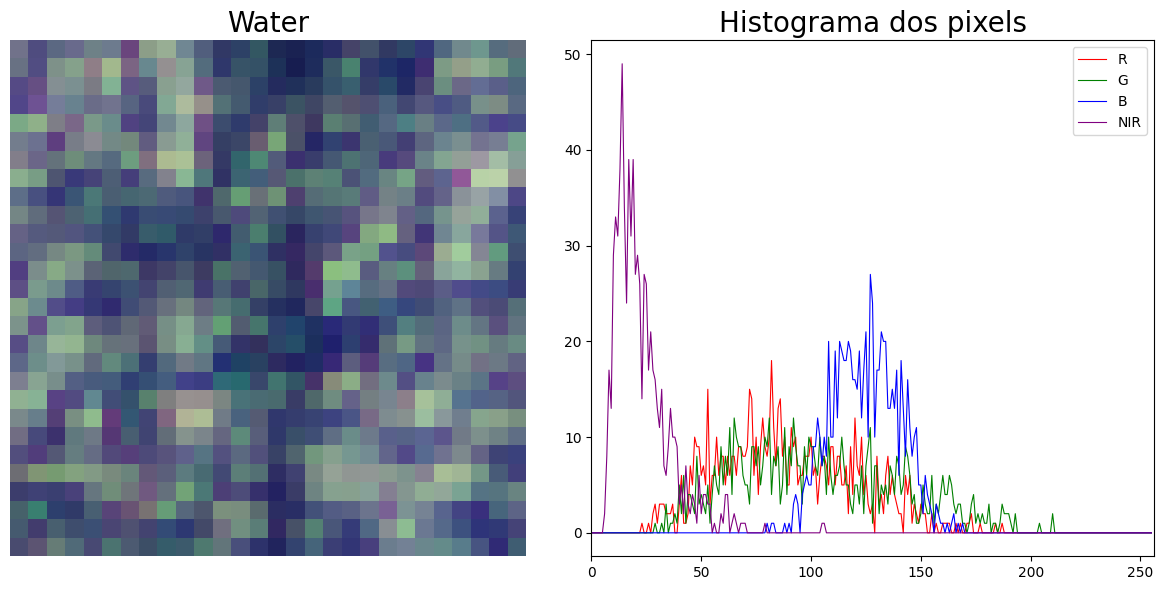

In [14]:
show_sample_histogram(x_train, y_train) #index = n

In [18]:
x_train_partial, x_validation, y_train_partial, y_validation = train_test_split(
    x_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

print(x_train_partial.shape)
print(x_validation.shape)
print(y_train_partial.shape)
print(y_validation.shape)

(226800, 28, 28, 4)
(97200, 28, 28, 4)
(226800,)
(97200,)


In [ ]:
class TrainingModel:

  def __init__(self, id, predictor):
    self.id = id
    self.predictor = predictor
    self.start_time = None
    self.duration = None
    self.accuracy = None
    self.loss = None
    self.history = None

  def __str__(self):
    return f"{self.id}: {self.predictor}"

  # training time
  def start_timer(self):
    self.start_time = datetime.now()
    
  def stop_timer(self):
    end_time = datetime.now()
    duration = (end_time - self.start_time).total_seconds()
    self.duration = duration
    
  def get_duration(self):
    return self.duration

  # accuracy
  def set_accuracy(self, value):
    self.accuracy = value
    
  def get_accuracy(self):
    return self.accuracy

  # loss
  def set_loss(self, value):
    self.loss = value
    
  def get_loss(self):
    return self.loss

  # execution history
  def set_history(self, value):
    self.history = value
    
  def get_history(self):
    return self.history